1. IMPORTING


In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models
import numpy as np
import os
import matplotlib.pyplot as plt


2: LOAD DATASET

In [2]:
img_size = (224, 224)
batch_size = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data/processed/train",
    image_size=img_size,
    batch_size=batch_size,
    seed=42
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data/processed/val",
    image_size=img_size,
    batch_size=batch_size,
    seed=42
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data/processed/test",
    image_size=img_size,
    batch_size=batch_size
)

# Get class names
class_names = train_ds.class_names
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")

# Prefetch
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)


Found 507 files belonging to 9 classes.
Found 142 files belonging to 9 classes.
Found 82 files belonging to 9 classes.
Number of classes: 9
Class names: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


3. BUILDING MODEL

In [3]:
base_model = MobileNet(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(len(class_names), activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,493,577 (13.33 MB)

 Trainable params: 264,713 (1.01 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

4. TRAIN

In [4]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - accuracy: 0.3156 - loss: 2.0090 - val_accuracy: 0.6831 - val_loss: 1.0998
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 230ms/step - accuracy: 0.5838 - loss: 1.1569 - val_accuracy: 0.6620 - val_loss: 0.9488
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 281ms/step - accuracy: 0.6686 - loss: 0.9245 - val_accuracy: 0.7887 - val_loss: 0.6715
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 276ms/step - accuracy: 0.7120 - loss: 0.7749 - val_accuracy: 0.7535 - val_loss: 0.7363
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 287ms/step - accuracy: 0.7574 - loss: 0.6585 - val_accuracy: 0.8732 - val_loss: 0.4861
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 285ms/step - accuracy: 0.8087 - loss: 0.5639 - val_accuracy: 0.8521 - val_loss: 0.4630
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 310ms/step - accuracy: 0.8008 - loss: 0.5070 - val_accuracy: 0.8169 - val_loss: 0.4875
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 282ms/step - accuracy: 0.8462 - loss: 0.4280 - val_accuracy: 0

5. Plot Training & Validation Accuracy/Loss

In [5]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'], label='Training Accuracy')
    plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'], label='Training Loss')
    plt.plot(hist.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


6. Fine-Tuning

Epoch 1/10


32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.2623 - loss: 6.0297 - val_accuracy: 0.3028 - val_loss: 4.1758
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.3452 - loss: 4.5231 - val_accuracy: 0.3380 - val_loss: 4.0154
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.3984 - loss: 3.2606 - val_accuracy: 0.3944 - val_loss: 3.2976
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.5207 - loss: 2.3080 - val_accuracy: 0.4859 - val_loss: 2.5664
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.5957 - loss: 1.7807 - val_accuracy: 0.5845 - val_loss: 1.9981
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6627 - loss: 1.3989 - val_accuracy: 0.6338 - val_loss: 1.5354
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6963 - loss: 1.0410 - val_accuracy: 0.7042 - val_loss: 1.1737
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7554 - loss: 0.9179 - val_accuracy: 0.7676 - val_loss: 0.9102
Epo

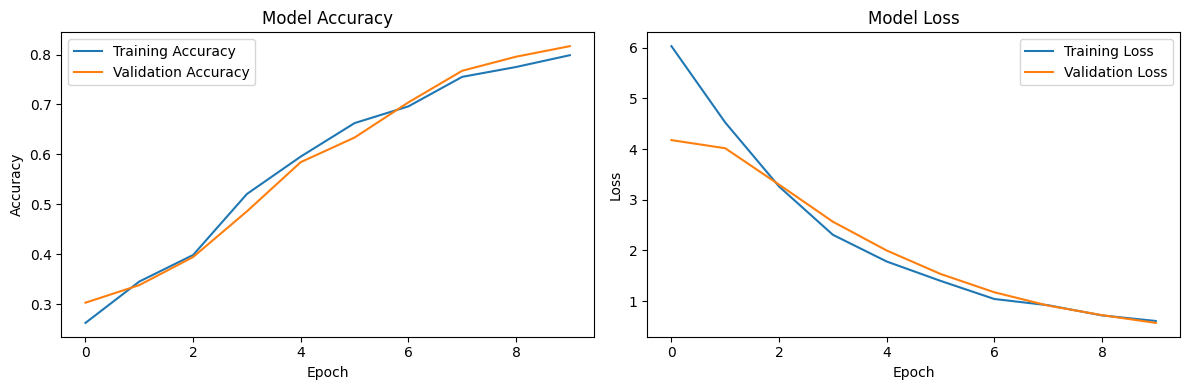

In [6]:
def unfreeze_model(model):
    for layer in model.layers[-10:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, 
        loss="sparse_categorical_crossentropy", 
        metrics=["accuracy"] # classes are integers
    )

unfreeze_model(model)

epochs = 10 
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
plot_hist(hist)


7. EVALUATE ON TEST SET

In [7]:
test_loss, test_acc = model.evaluate(test_ds)
print("TEST ACCURACY:", test_acc)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.7317 - loss: 0.8804
TEST ACCURACY: 0.7317073345184326


8. SAVE MODEL

In [8]:
os.makedirs('Models/MobileNet', exist_ok=True)
model.save('Models/MobileNet/mobilenet_model.keras')
print("Model saved as .keras file!")


Model saved as .keras file!


9. LOAD MODEL

In [9]:
import os
from tensorflow import keras

model_path = 'Models/MobileNet/mobilenet_model.keras'

if os.path.exists(model_path):
    loaded_model = keras.models.load_model(model_path)
    print("Model loaded successfully!")
else:
    print("File not found", model_path)


Model loaded successfully!
